Importing Library

In [1]:
import os, sklearn, math
import pandas as pd # pandas
import tensorflow as tf # tensorflow
from tensorflow.keras import layers # keras
import matplotlib.pyplot as plt # matplotlib for plotting
from joblib import dump, load

tf.random.set_seed(42) # Randon seed loading 42 is example

Data importing

In [2]:
data = '230731_test_control' # Experimental data name to load (it has to be csv file)
dataname = data+'Tension'+'_0731' # Ouput name
filename = 'myLearningData/'+data+'.csv' # Setting route of experimental data
SD = pd.read_csv(filename) # Loading experimental data to dataframe by pandas
SD=SD.iloc[:,:5] # Pandas code: (:)All row (5) five columns
SensorData = SD # Rename

In [3]:
SD

,Pre,Resist,Tension,Unnamed: 3,Unnamed: 4
0,17.45,17.45,0.1,NaN,NaN
1,17.45,17.54,0.2,NaN,NaN
2,17.54,17.45,0.3,NaN,NaN
3,17.45,17.54,0.3,NaN,NaN
4,17.54,17.54,0.5,NaN,NaN
...,...,...,...,...,...
1620,17.19,17.19,2.5,NaN,NaN
1621,17.19,17.11,2.7,NaN,NaN
1622,17.11,17.19,2.7,NaN,NaN
1623,17.19,17.11,2.4,NaN,NaN


In [4]:
SD.describe()

,Pre,Resist,Tension,Unnamed: 3,Unnamed: 4
count,1625.000000,1625.000000,1625.000000,0.0,0.0
mean,21.431292,21.431083,26.389415,NaN,NaN
std,2.382102,2.382467,16.771352,NaN,NaN
min,16.940000,16.940000,-6.000000,NaN,NaN
25%,19.410000,19.410000,12.400000,NaN,NaN
50%,21.790000,21.790000,27.100000,NaN,NaN
75%,23.500000,23.500000,40.400000,NaN,NaN
max,25.190000,25.190000,58.700000,NaN,NaN


In [5]:
X = SD.iloc[:,[0,1]]
X.sample(5)

,Pre,Resist
63,18.42,18.33
1455,21.69,21.69
1403,22.89,22.89
1151,23.40,23.50
274,22.58,22.78


In [6]:
# SD['Resistance'] = (SD['Resistance']-SD['Resistance'].mean())/(SD['Resistance'].max()-SD['Resistance'].min())*2
# SD['Pre'] = (SD['Pre']-SD['Pre'].mean())/(SD['Pre'].max()-SD['Pre'].min())*2
# SD['Displacement'] = (SD['Displacement']-SD['Displacement'].mean())/(SD['Displacement'].max()-SD['Displacement'].min())*2
SD['Tension'] = (SD['Tension']-SD['Tension'].mean())/(SD['Tension'].max()-SD['Tension'].min())*2

In [7]:
X = SD.iloc[:,[0,1]]
X['index'] = X.index+1
X = X[['index','Pre','Resist']]
y = SD.iloc[:,[2]]
#y['index'] = y.index+1
#y = y[['index','Time','Distance']]

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_11468\529097882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['index'] = X.index+1


In [8]:
X.sample(5)

,index,Pre,Resist
294,295,22.99,22.99
1041,1042,21.49,21.49
396,397,24.98,24.98
100,101,19.05,19.05
1249,1250,24.87,24.87


In [9]:
y.sample(5)

,Tension
822,-0.871388
1274,0.668024
257,0.399091
189,0.151796
625,-0.358251


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.01, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.20, random_state=42)


In [11]:
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)

print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  1286 ea 79 %    X_valid:  322 ea 19 %    X_test:  17 ea 1 %


In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [13]:
X_train.shape

(1286, 1, 3)

In [14]:
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_LSTM'+'_SS.pkl'
dump(scaler, file_name)

['myScaler/230731_test_controlTension_0731)_LSTM_SS.pkl']

In [15]:
from tensorflow import keras
model = keras.models.Sequential([
    keras.layers.LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.LSTM(64, activation='relu', return_sequences=True),
    keras.layers.LSTM(64, activation='elu', return_sequences=True),
    keras.layers.LSTM(64, activation='elu', return_sequences=True),
    keras.layers.LSTM(8),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.RMSprop(learning_rate=1e-6, rho = 0.9))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             17408     
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             33024     
                                                                 
 lstm_2 (LSTM)               (None, 1, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 1, 64)             33024     
                                                                 
 lstm_4 (LSTM)               (None, 8)                 2336      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 118,825
Trainable params: 118,825
Non-trai

## Callback (best, early stopping, tensorboard)

In [17]:
import os 
#root_logdir = os.path.join(os.curdir, 'mylog/'+data)
root_logdir = os.path.join(os.curdir, 'mylog/'+'230703_c01')

def get_run_logdir():
    import time
    run_id= time.strftime("%m%d_%Hh%Mm%Ss"+dataname)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [18]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [19]:
dataname

'230731_test_controlTension_0731)'

In [20]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
n_epochs = 300
batch_size = 1
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=n_epochs, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle,early_stopping_cb,tensorboard_cb])
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:5]
y_pred = model.predict(X_new)

Epoch 1/300
41/41 [==============================] - 7s 32ms/step - loss: 0.2657 - val_loss: 0.2838
Epoch 2/300
41/41 [==============================] - 0s 8ms/step - loss: 0.2646 - val_loss: 0.2830
Epoch 3/300
41/41 [==============================] - 0s 9ms/step - loss: 0.1621 - val_loss: 0.0772
Epoch 4/300
41/41 [==============================] - 0s 9ms/step - loss: 0.0639 - val_loss: 0.0644
Epoch 5/300
41/41 [==============================] - 0s 8ms/step - loss: 0.0593 - val_loss: 0.0734
Epoch 6/300
41/41 [==============================] - 0s 9ms/step - loss: 0.0513 - val_loss: 0.0557
Epoch 7/300
41/41 [==============================] - 0s 8ms/step - loss: 0.0397 - val_loss: 0.0327
Epoch 8/300
41/41 [==============================] - 0s 10ms/step - loss: 0.0250 - val_loss: 0.0169
Epoch 9/300
41/41 [==============================] - 0s 10ms/step - loss: 0.0175 - val_loss: 0.0090
Epoch 10/300
41/41 [==============================] - 0s 10ms/step - loss: 0.0123 - val_loss: 0.0223
Epoch

In [21]:
%load_ext tensorboard
%tensorboard --logdir=./mylog/230703

Reusing TensorBoard on port 6006 (pid 45992), started 27 days, 21:11:39 ago. (Use '!kill 45992' to kill it.)

In [22]:
model.save('H:/Jupyter_project/wearableActuator/myModel/'+dataname+'_LSTM'+'.h5')

In [23]:
model = tf.keras.models.load_model('myModel/'+dataname+'_LSTM'+'.h5')
scaler = load(file_name)
valid_predictions = model.predict(X_valid)

11/11 [==============================] - 1s 2ms/step


In [24]:
X_valid

array([[[-0.05861252, -1.51155491, -1.55018932]],

       [[-0.28253876, -0.28682013, -0.28710376]],

       [[ 0.8072356 ,  1.31959569,  1.27391893]],

       [[-0.24841667, -0.44620342, -0.44656307]],

       [[-0.92019539,  1.40767593,  1.36623747]],

       [[ 0.52572833,  0.24166131,  0.19966675]],

       [[-0.11406093, -1.25150849, -1.2522522 ]],

       [[ 1.33612806,  0.24166131,  0.24162973]],

       [[-0.83915542,  1.40767593,  1.36623747]],

       [[ 0.76031773,  1.05535497,  1.05571145]],

       [[-0.35718084,  0.16196967,  0.16190008]],

       [[-1.69220776, -1.58705226, -1.62152638]],

       [[ 1.23802704,  0.66528533,  0.57733353]],

       [[-0.83275752,  1.31959569,  1.36623747]],

       [[-1.60050463, -1.28925716, -1.29001887]],

       [[ 0.63662514,  0.62334236,  0.57733353]],

       [[ 1.37238278,  0.07808372,  0.07797413]],

       [[ 1.0141008 ,  1.23151545,  1.27391893]],

       [[-1.03322482,  0.96727473,  1.00955218]],

       [[-1.1078669 ,  0.665285

In [25]:
valid_predictions

array([[-0.7436313 ],
       [-0.5636999 ],
       [ 0.71889466],
       [-0.5939934 ],
       [ 0.66219217],
       [ 0.3072824 ],
       [-0.7136819 ],
       [-0.10686892],
       [ 0.60686564],
       [ 0.6260158 ],
       [-0.41422498],
       [-0.60716844],
       [ 0.11978364],
       [ 0.57764703],
       [-0.39740872],
       [ 0.4488889 ],
       [-0.18767218],
       [ 0.6292584 ],
       [ 0.5638387 ],
       [ 0.46528345],
       [ 0.43253297],
       [-0.00156182],
       [ 0.7944505 ],
       [-0.45138654],
       [-0.19536483],
       [-0.23999444],
       [ 0.3030178 ],
       [ 0.24451861],
       [-0.4073062 ],
       [ 0.20410217],
       [ 0.677331  ],
       [-0.19221473],
       [ 0.02904065],
       [ 0.25729406],
       [-0.06701937],
       [-0.6443955 ],
       [-0.66681   ],
       [-0.58714443],
       [ 0.27473363],
       [-0.5294828 ],
       [-0.19063482],
       [ 0.6235775 ],
       [ 0.6304757 ],
       [ 0.40126246],
       [ 0.6137774 ],
       [-0

In [26]:
X_test[0]

array([[-1.44908784, -0.68108407, -0.68155573]])

In [27]:
arr = X_test
X_test0 = arr[:1]
X_test0

array([[[-1.44908784, -0.68108407, -0.68155573]]])

In [28]:
valid_predictions_df=pd.DataFrame(valid_predictions)
valid_predictions_df.columns = ["Tension"]
valid_predictions_df

,Tension
0,-0.743631
1,-0.563700
2,0.718895
3,-0.593993
4,0.662192
...,...
317,-0.772337
318,0.130072
319,0.322784
320,-0.196935


In [29]:
k= y_valid.to_numpy()
k_df = pd.DataFrame(k)
k_df.columns  = ["Valid_Tension"]
k_df

,Valid_Tension
0,-0.970307
1,-0.605546
2,0.930775
3,-0.679735
4,0.708210
...,...
317,-0.914665
318,0.074516
319,0.256896
320,-0.240786


In [30]:
k_df.describe()

,Valid_Tension
count,322.000000
mean,0.036778
std,0.529433
min,-0.988854
25%,-0.398436
50%,0.085335
75%,0.490281
max,0.998782


In [31]:
ValidPre = pd.concat( [k_df,valid_predictions_df],axis=1)
ValidPre.head(5)
corr = ValidPre.corr()
print("corr")
for i in range(0,1):    
    print(format(corr[valid_predictions_df.columns[i]][k_df.columns[i]]*100,'.2f')+'%',k_df.columns[i])
corr

corr
99.23% Valid_Tension


,Valid_Tension,Tension
Valid_Tension,1.000000,0.992317
Tension,0.992317,1.000000


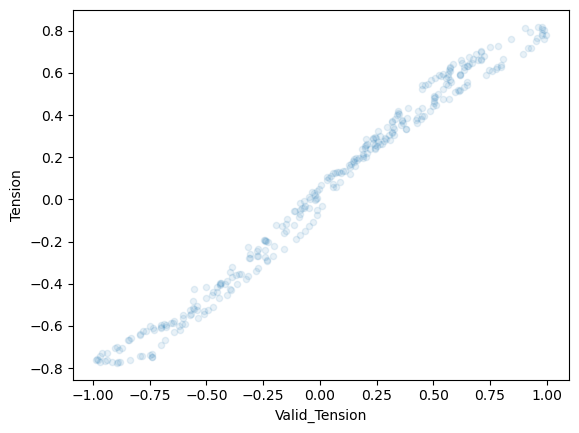

In [32]:
alpa=0.1

ValidPre.plot(kind="scatter", x= "Valid_Tension",y= "Tension",alpha = alpa)
plt.savefig('H:/Jupyter_project/wearableActuator/savefig/0710/hidden_combo/'+dataname+'Relu_combo-all-64N-4L-rere_pre'+'.png')
